# Summarise the attribution analysis

In this notebook we generate a number of plots demonstrating the statistical attribution of phenology trends

In [1]:
import os
import sys
import xvec
import pickle
import scipy
import textwrap
import warnings
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
from scipy import stats
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
import distinctipy
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg
from _utils import round_coords

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Open data


In [2]:
#phenology data
p_attribution = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_vPOS_perpixel.nc'), crs='EPSG:4326')
p_parcorr = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/parcorr_phenology_perpixel.nc'), crs='EPSG:4326')
p_trends = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/trends_phenology_perpixel.nc'), crs='EPSG:4326')

# cropping for masking
crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = xr.where(crops==3, 0, 1) #rainfed crops
crops = round_coords(crops)

# some other enviro datasets for plots
wcf = xr.open_dataarray('/g/data/os22/chad_tmp/AusENDVI/data/5km/WCF_5km_monthly_1982_2022.nc')
wcf = wcf.mean('time')
vegh = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/VegH_5km_monthly_1982_2022.nc')['VegH']
vegh = vegh.mean('time')

#moisture index
mi = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/MI_1982_2022.nc')
mi = mi.mean('time')
mi = assign_crs(mi, crs='EPSG:4326')
mi = mi.rename('P:PET')
mi = xr.where(mi>5, np.nan, mi) #remove extreme values

#IBRA subregions data if summarise across the regions (mostly superceeded)
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
gdf = gpd.read_file(ecoregions_file)

## Mask significance and cropping

In [3]:
p_attribution = p_attribution.where(crops)
p_parcorr = p_parcorr.where(crops)
p_trends = p_trends.where(crops)

sig_mask = xr.where(p_trends.vPOS_p_value<=0.05, 1, 0)

vPOS_trends = p_trends.vPOS_slope.where(sig_mask)

p_attribution = p_attribution.where(sig_mask)

## Summary plots

### Climate atttribution for vPOS trends

In [4]:
clim_most_important_var = allNaN_arg(np.abs(p_attribution.PLS_coefficent), dim='feature',stat='max', idx=False)

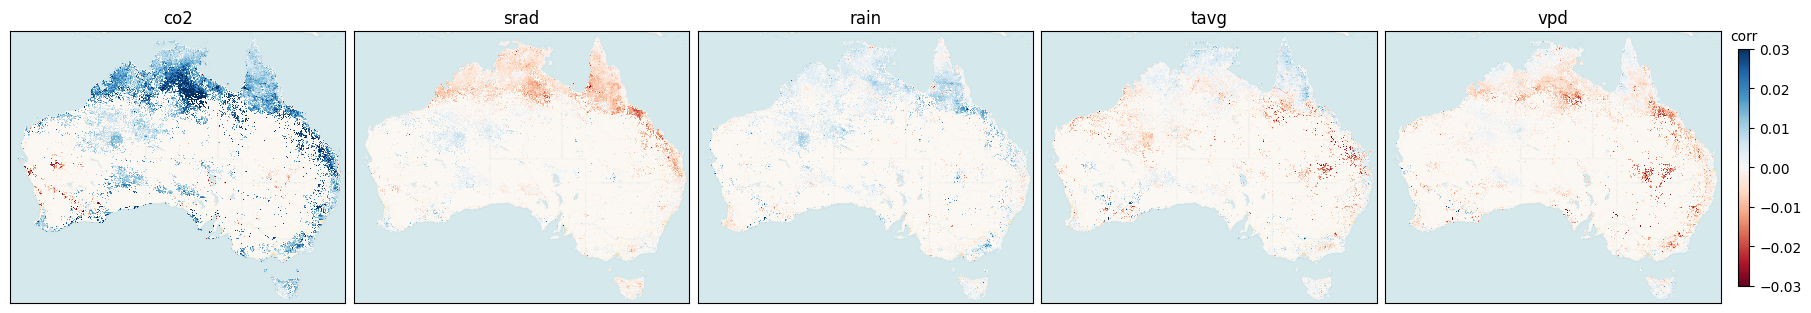

In [5]:
fig,axes=plt.subplots(1,5,figsize=(18,6), layout='constrained')

vmin,vmax=-0.03,0.03
for v,ax in zip(p_attribution.feature.values,axes.ravel()):
    p_attribution.sel(feature=v).PLS_coefficent.plot(add_labels=False,ax=ax,vmin=vmin,vmax=vmax,cmap='RdBu', add_colorbar=False)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title(v)

norm = colors.Normalize(vmin=vmin, vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm, cmap='RdBu')
ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.4)
ax_cbar.ax.set_title('corr', fontsize=10);

#### Plot

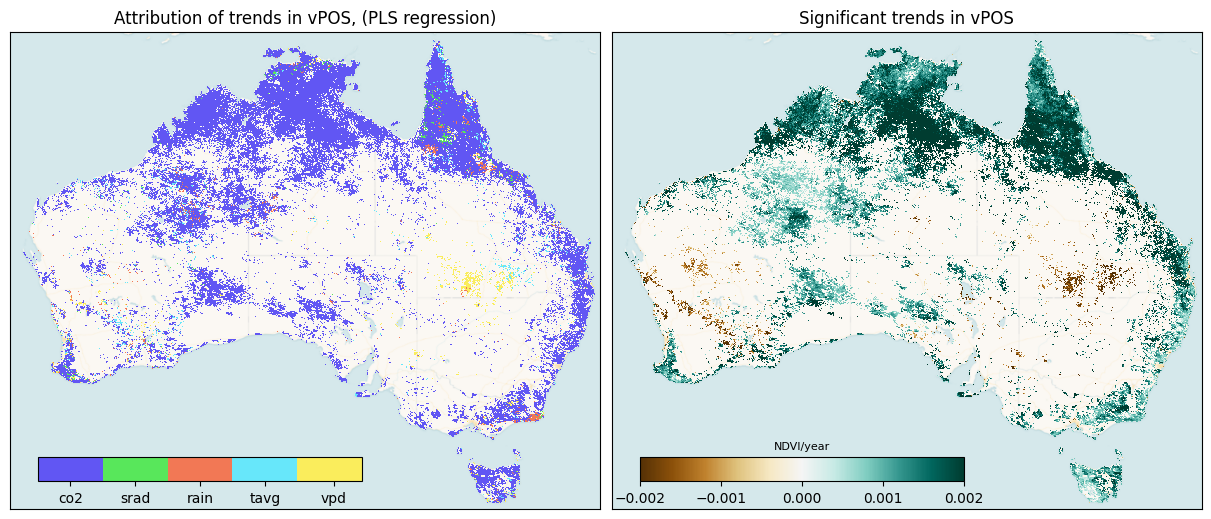

In [6]:
fig,ax=plt.subplots(1,2,figsize=(12,6), layout='constrained', sharey=True)

categories = list(p_attribution.feature.values)
colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

im = clim_most_important_var.plot(add_colorbar=False,ax=ax[0], add_labels=False, cmap=cmap)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])

axins1 = inset_axes(ax[0],width="55%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1, ticks=[0.4,1.2,2,2.8, 3.65],orientation='horizontal')
cbar.ax.set_xticklabels(categories)

im1 = vPOS_trends.plot(ax=ax[1], cmap='BrBG', add_colorbar=False, add_labels=False, vmin=-0.002, vmax=0.002)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

axins1 = inset_axes(ax[1],width="55%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im1, cax=axins1, orientation='horizontal')
cbar.ax.set_title('NDVI/year', fontsize=8)
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([]);

ax[0].set_title('Attribution of trends in vPOS, (PLS regression)')
ax[1].set_title('Significant trends in vPOS');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/attribution_vPOS_AusENDVI.png',
            bbox_inches='tight', dpi=300)

## Relationship between environmental gradients and CO2 sensitivity

### CO2 sensitivity

In [7]:
# p_attribution = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/attribution_vPOS_perpixel.nc'), crs='EPSG:4326')
# p_attribution = p_attribution.where(crops)

In [8]:
co2 = p_attribution.sel(feature='co2').PLS_coefficent.where(p_attribution.sel(feature='co2').PLS_coefficent>0).drop_vars('feature')
co2_df = co2.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

co2_df['P:PET'] = mi.where(~np.isnan(co2)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
co2_df['WCF'] = wcf.where(~np.isnan(co2)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
co2_df['VegH'] = vegh.where(~np.isnan(co2)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

co2_df = co2_df.dropna()

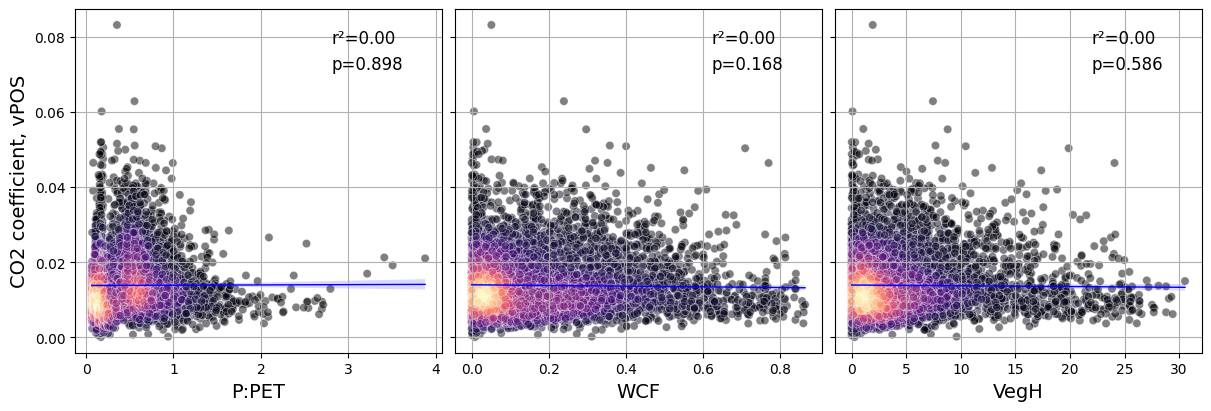

In [9]:
vars = ['P:PET', 'WCF', 'VegH']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,ax in zip(vars, axes.ravel()): 
    obs,pred = co2_df[v].values, co2_df['PLS_coefficent'].values
    mask = ~np.isnan(obs) & ~np.isnan(pred)
    sl, i, r, p, s = stats.linregress(obs[mask],pred[mask])
    r2 = r**2
    
    xy = np.vstack([obs[mask],pred[mask]])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=co2_df, x=v,y='PLS_coefficent', alpha=0.5, ax=ax, c=z, cmap='magma')
    sb.regplot(data=co2_df, x=v,y='PLS_coefficent',  scatter=False,
               line_kws={'linewidth':1}, color='blue', ax=ax, robust=True)
    # ax.set_ylim(0, 0.08)
    # ax.set_title()
    ax.grid()
    ax.set_ylabel('CO2 coefficient, vPOS', fontsize=14)
    ax.set_xlabel(v, fontsize=14)
    ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=12)
    ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12);
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/CO2_sensitivity_vPOS_AusENDVI.png',
            bbox_inches='tight', dpi=300)

### vPOS trends across same gradients

In [10]:
vPOS_df = vPOS_trends.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

vPOS_df['P:PET'] = mi.where(~np.isnan(vPOS_trends)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
vPOS_df['WCF'] = wcf.where(~np.isnan(vPOS_trends)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
vPOS_df['VegH'] = vegh.where(~np.isnan(vPOS_trends)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

vPOS_df = vPOS_df.dropna()

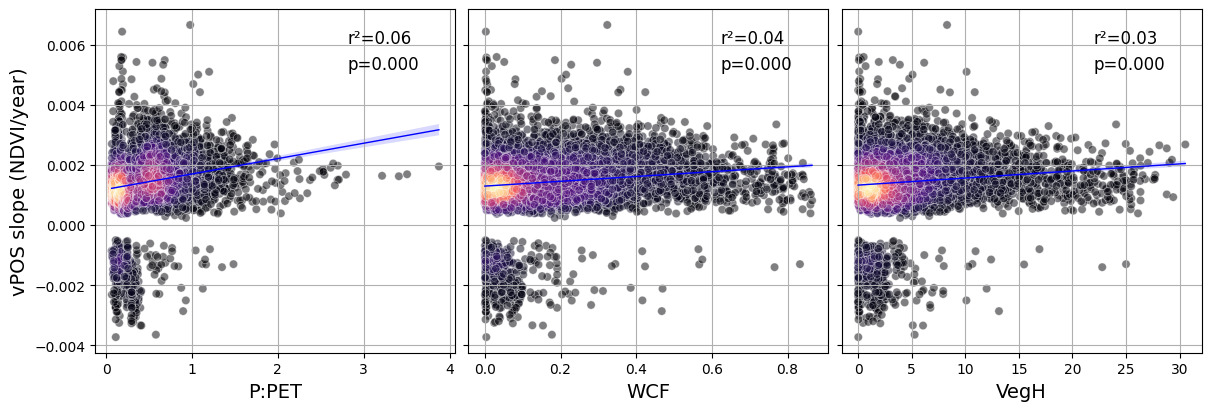

In [11]:
vars = ['P:PET', 'WCF', 'VegH']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,ax in zip(vars, axes.ravel()): 
    obs,pred = vPOS_df[v].values, vPOS_df['vPOS_slope'].values
    mask = ~np.isnan(obs) & ~np.isnan(pred)
    sl, i, r, p, s = stats.linregress(obs[mask],pred[mask])
    r2 = r**2
    
    xy = np.vstack([obs[mask],pred[mask]])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=vPOS_df, x=v,y='vPOS_slope', alpha=0.5, ax=ax, c=z, cmap='magma')
    sb.regplot(data=vPOS_df, x=v,y='vPOS_slope',  scatter=False,
               line_kws={'linewidth':1}, color='blue', ax=ax, robust=True)
    # ax.set_ylim(0, 0.08)
    # ax.set_title()
    ax.grid()
    ax.set_ylabel('vPOS slope (NDVI/year)', fontsize=14)
    ax.set_xlabel(v, fontsize=14)
    # ax.axhline(0, color='grey', linestyle='--')
    ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
            transform=ax.transAxes, fontsize=12)
    ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12);
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/vPOS_slope_enviro_gradients_AusENDVI.png',
            bbox_inches='tight', dpi=300)

### Same relationships but binning covariables

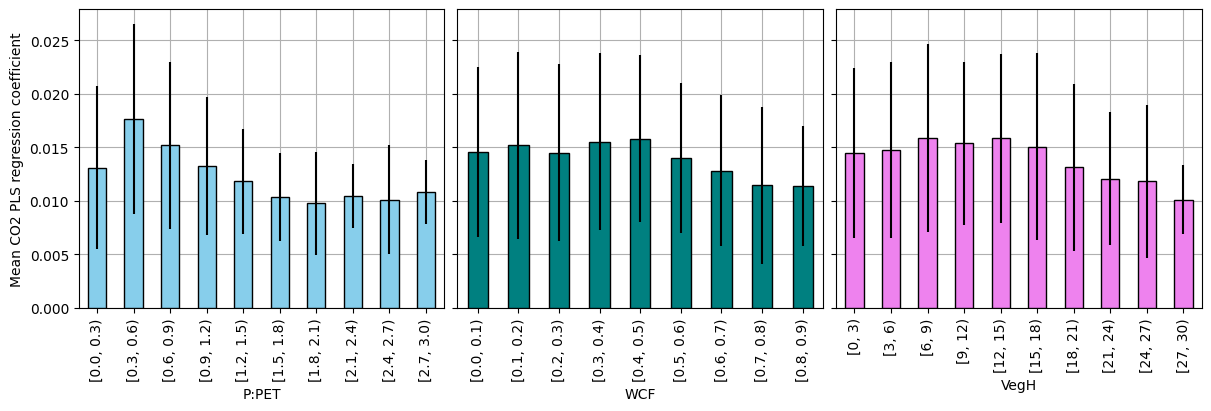

In [31]:
vars = ['P:PET', 'WCF', 'VegH']
bins = [
    np.arange(0,3.3,0.3),
    np.arange(0,1, 0.1),
    np.arange(0,33, 3)
]
cls = ['skyblue', 'teal', 'violet']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,b,ax,c in zip(vars,bins, axes.ravel(), cls): 
    bins = pd.cut(co2_df[v], bins=b, right=False)
    grouped = co2_df.groupby(bins, observed=True)['PLS_coefficent'].mean()
    stddev = co2_df.groupby(bins, observed=True)['PLS_coefficent'].std()
    grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev)
    ax.set_xlabel(v)
    ax.grid()
    ax.set_ylabel('Mean CO2 PLS regression coefficient');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/CO2_sensitivity_vPOS_bins_AusENDVI.png',
            bbox_inches='tight', dpi=300)

In [15]:
# vPOS_df = p_trends.vPOS_slope.to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

# vPOS_df['P:PET'] = mi.where(~np.isnan(p_trends.vPOS_slope)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
# vPOS_df['WCF'] = wcf.where(~np.isnan(p_trends.vPOS_slope)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)
# vPOS_df['VegH'] = vegh.where(~np.isnan(p_trends.vPOS_slope)).to_dataframe().reset_index(drop=True).drop(['spatial_ref'],axis=1)

# vPOS_df = vPOS_df.dropna()

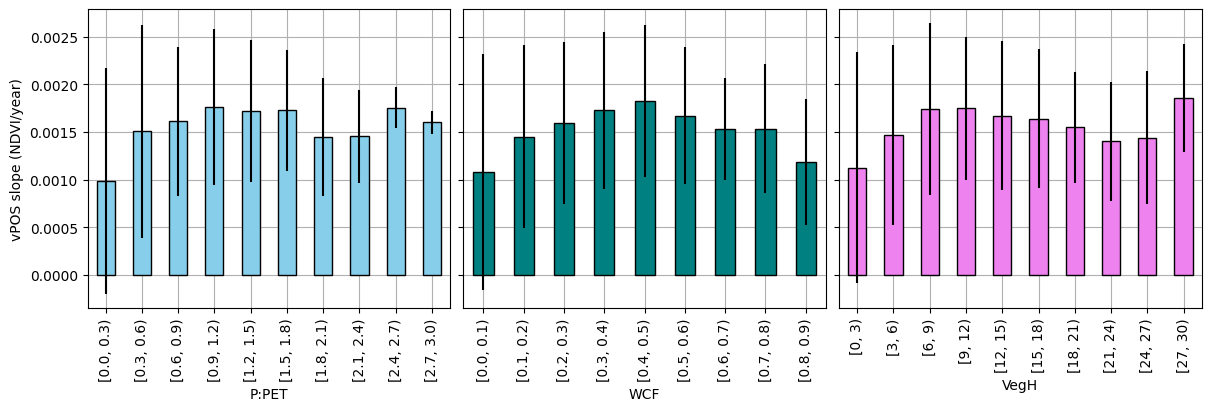

In [16]:
vars = ['P:PET', 'WCF', 'VegH']
bins = [
    np.arange(0,3.3,0.3),
    np.arange(0,1, 0.1),
    np.arange(0,33, 3)
]
cls = ['skyblue', 'teal', 'violet']
fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)

for v,b,ax,c in zip(vars,bins, axes.ravel(), cls): 
    bins = pd.cut(vPOS_df[v], bins=b, right=False)
    grouped = vPOS_df.groupby(bins, observed=True)['vPOS_slope'].mean()
    stddev = vPOS_df.groupby(bins, observed=True)['vPOS_slope'].std()
    grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev)
    ax.set_xlabel(v)
    ax.grid(zorder=-10)
    ax.set_ylabel('vPOS slope (NDVI/year)');
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/vPOS_slope_enviro_gradients_bins_AusENDVI.png',
            bbox_inches='tight', dpi=300)

## Partial correlations with IOS trends

In [33]:
categories = list(p_parcorr.data_vars)
colours = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap = LinearSegmentedColormap.from_list("cwc", colours, N=len(categories))

categories1 = ['values', 'timing']
colours1 = distinctipy.get_colors(len(categories1), pastel_factor=0.5, rng=2)
cmap1 = LinearSegmentedColormap.from_list("cwc", colours1, N=len(categories1))

ios_most_important_var = allNaN_arg(p_parcorr.to_array(), dim='variable',stat='max', idx=False)
values_or_timing = xr.where(ios_most_important_var.isin([0,1,2]), 1, 2)

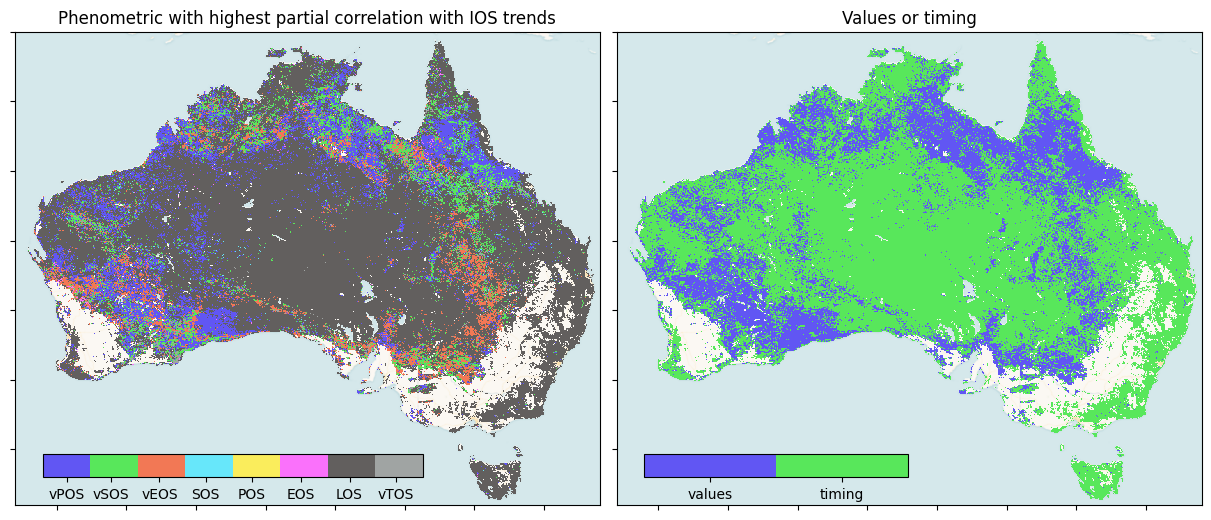

In [34]:
fig,ax=plt.subplots(1,2,figsize=(12,6), layout='constrained')
im = ios_most_important_var.plot(ax=ax[0], add_colorbar=False, add_labels=False, cmap=cmap)
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[0].set_title('Phenometric with highest partial correlation with IOS trends');

axins1 = inset_axes(ax[0],width="65%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im,cax=axins1, ticks=[0.45,1.25,2.15,3,3.85,4.75,5.65,6.5],orientation='horizontal')
cbar.ax.set_xticklabels(list(p_parcorr.data_vars));

im = values_or_timing.where(~np.isnan(ios_most_important_var)).plot(ax=ax[1], add_colorbar=False, add_labels=False, cmap=cmap1)
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_title('Values or timing');

axins1 = inset_axes(ax[1],width="45%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1, ticks=[1.25,1.75],orientation='horizontal')
cbar.ax.set_xticklabels(['values', 'timing']);

fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/parcorr_perpixel_AusENDVI.png',
            bbox_inches='tight', dpi=300)

In [19]:
#### Summarise over IBRA regions

# Using the mode statistics
# clim_most_important_var.name='PLS_coefficent_max'
# clim_most_important_var_gdf = clim_most_important_var.drop_vars('spatial_ref').xvec.zonal_stats(
#     gdf.geometry, x_coords="longitude", y_coords="latitude",
#     stats=[
#         ("mode", scipy.stats.mode, {'nan_policy':'omit'}),
#         # ('count', np.unique, {'return_counts':True, 'equal_nan':True})
#           ]
# ).xvec.to_geodataframe()

# clim_most_important_var_gdf = clim_most_important_var_gdf.dropna()
# clim_most_important_var_gdf['mode'] = [i[0] for i in clim_most_important_var_gdf['PLS_coefficent_max']]
# clim_most_important_var_gdf['count'] = [i[1] for i in clim_most_important_var_gdf['PLS_coefficent_max']]
# clim_most_important_var_gdf = clim_most_important_var_gdf[clim_most_important_var_gdf['count'] >75]

In [20]:
# ios_most_important_var.name='IOS_most_important_var'
# ios_most_important_var_gdf = ios_most_important_var.drop_vars('spatial_ref').xvec.zonal_stats(
#     gdf.geometry, x_coords="longitude", y_coords="latitude", stats=[("mode", scipy.stats.mode, {'nan_policy':'omit'})]
# ).xvec.to_geodataframe()

# ios_most_important_var_gdf = ios_most_important_var_gdf.dropna()
# ios_most_important_var_gdf['IOS_most_important_var'] = [i[0] for i in ios_most_important_var_gdf['IOS_most_important_var']]

# values_or_timing.name='values_or_timing'
# values_or_timing_gdf = values_or_timing.drop_vars('spatial_ref').xvec.zonal_stats(
#     gdf.geometry, x_coords="longitude", y_coords="latitude", stats=[("mode", scipy.stats.mode, {'nan_policy':'omit'})]
# ).xvec.to_geodataframe()

# values_or_timing_gdf = values_or_timing_gdf.dropna()
# values_or_timing_gdf['values_or_timing'] = [i[0] for i in values_or_timing_gdf['values_or_timing']]

In [21]:
# fig,ax=plt.subplots(1,2,figsize=(12,6), layout='constrained', sharey=True)
# im = ios_most_important_var_gdf.plot(column='IOS_most_important_var', ax=ax[0], legend=False, cmap=cmap)
# ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[0].set_yticklabels([])
# ax[0].set_xticklabels([])
# ax[0].set_title('Phenometric with highest partial correlation with IOS trends');

# axins1 = inset_axes(ax[0],width="55%",height="5%",loc="lower left", borderpad=2)
# # norm = colors.Normalize()
# cbar = plt.cm.ScalarMappable(cmap=cmap)
# ax_cbar = fig.colorbar(cbar, cmap=cmap, cax=axins1, ticks=[0.09,0.25,0.4,0.6,0.75,0.925], orientation='horizontal')
# ax_cbar.ax.set_xticklabels(list(p_parcorr.data_vars));

# im = values_or_timing_gdf.plot(ax=ax[1],  cmap=cmap1)
# ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
# ax[1].set_yticklabels([])
# ax[1].set_xticklabels([])
# ax[1].set_title('Values or timing');

# axins1 = inset_axes(ax[1],width="55%",height="5%",loc="lower left", borderpad=2)
# # norm = colors.Normalize()
# cbar = plt.cm.ScalarMappable(cmap=cmap1)
# ax_cbar = fig.colorbar(cbar, cmap=cmap1, cax=axins1, ticks=[0.25,0.75], orientation='horizontal')
# ax_cbar.ax.set_xticklabels(['values', 'timing']);